In [1]:
import obspy
import hypopy
import matplotlib.pyplot as plt
import numpy as np
from obspy.signal.trigger import pk_baer,ar_pick


# Input and Output File name


In [2]:
Station_filename="Station"
Model_name="Model1"
Phase_filename="Picked_Phases"
Output_filename="Located_eq"

# Downloading the Station Data

In [ ]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client

client = Client("IRIS")
t = UTCDateTime("2011-03-11T05:46:23")  # Tohoku
inv = client.get_stations(network="II",station= "*",channel="*",minlatitude=-15,maxlatitude=85, minlongitude=70 ,maxlongitude=120,  starttime=t + 10 * 60, endtime=t + 30 * 60)
print(inv)

In [ ]:
network=inv[0]
n=len(network)
print("Total number of station in the Network= {}".format(n))

In [ ]:
inv.plot()

# Creating a Hypoinverse Station file

In [ ]:
network_name="II"
for i in range(n):
    hypopy.add_station(Station_filename,network[i].code,network_name,"BHZ",network[i].latitude,network[i].longitude,network[i].elevation)
    hypopy.add_station(Station_filename,network[i].code,network_name,"BH1",network[i].latitude,network[i].longitude,network[i].elevation)
    hypopy.add_station(Station_filename,network[i].code,network_name,"BH2",network[i].latitude,network[i].longitude,network[i].elevation)

# Downloading Waveform Data

In [ ]:
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy import Stream
stns=["AAK","COCO","BRVK","KAPI"]
st=Stream()
for stn in stns:
    try:
        
        client = Client("IRIS")
        t = UTCDateTime("2011-03-11T05:46:23")  # Tohoku
        st += client.get_waveforms("II", stn, "*", "BH*", t - 10 * 60, t + 30 * 60)
    except:
        pass

print(st)
#st.plot()

# Processing Waveform Data

In [ ]:
st.detrend("linear")
st.taper(max_percentage=0.05, type='cosine')

In [ ]:
st[0].stats.location

# Picking and adding P Phases

In [ ]:
#Automatic
for i in range(len(st)):
    station=st[i].stats.station
    net=st[i].stats.network
    df = st[i].stats.sampling_rate
    channel=st[i].stats.channel
    #p_pick, s_pick = ar_pick(st[0].data, st[1].data, st[2].data, df, 1.0, 20.0, 600.0, 40.0, 500.0, 40.0, 50, 50, 10, 20)
    p_pick, phase_info = pk_baer(st[i].data, df, 2000, 6000, 7700.0, 1220.0, 100, 100)
    #p_pick/df
    ax = plt.subplot(211)
    plt.plot(st[i].data, 'k')
    ymin, ymax = ax.get_ylim()
    plt.vlines(p_pick, ymin, ymax, color='r', linewidth=2)
    plt.axis('tight')
    plt.show()
    print("Your automatic P pick is at {} sample".format(p_pick))

    #Manual
    p_pick = int(input("Enter your accurate p_pick value: "))

    #p_pick=50004
    ax = plt.subplot(211)
    plt.plot(st[i].data, 'k')
    ymin, ymax = ax.get_ylim()
    plt.vlines(p_pick, ymin, ymax, color='r', linewidth=2)
    plt.axis('tight')
    plt.show()
    print("Your P pick is at {} sample".format(p_pick))
    trail=int(input("Do you want to keep this pick(1) or skip(2)?"))


    p_pick=p_pick/df
    t=st[0].stats.starttime
    p_arrival_time=t+p_pick
    if trail==1:
        hypopy.add_picks(Phase_filename,station,net,channel,p_arrival_time,s_arrival_time=0)
    
    else:
        continue
    #s_arrival_time=t+s_pick



# Creating a Phase File

In [ ]:
evid=2000001
trial_origintime=st[0].stats.starttime
trial_latitude=network[0].latitude
trial_longitude=network[0].longitude
hypopy.create_phase_file(Phase_filename,evid,trial_origintime,trial_latitude,trial_longitude)

# Creating A Velocity Model

Model file successfully created as Model1.crh


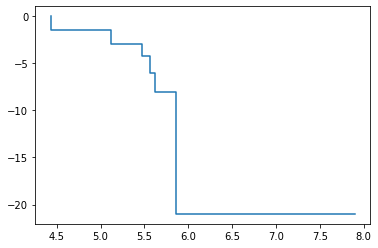

In [3]:
v=[4.43,5.12,5.47,5.56,5.62,5.86,7.9]
d=[0.0,1.5,3,4.25,6.0,8.00,21]
Model_name='Model1'
hypopy.model(Model_name,v,d)

plt.step(np.array(v),-np.array(d))

# Input file for Hypoinverse

In [4]:
hypopy.locate(Model_name,Station_filename,Phase_filename,Output_filename)

Open terminal in working directory run:
./hyp1.40
Then run:
@Located_eq.hyp


In [5]:
hypopy.export_located(Output_filename)
import pandas as pd
df=pd.read_csv("Located.csv")
df

ModuleNotFoundError: No module named 'pandas'